# Banknote Forgery Detection - Bayesian Classification

<br></br>
## <ins>Bayes Primer: 
What is Bayes Theorem, Where does it come from, and How do we use it?</ins>
### Bayes Theorem: 

$\large p(\theta|y) = \frac{p(y|\theta)*p(\theta)}{p(y)}$



### Where does bayes theorem come from? 

 If we wanted to find a joint probabilty like: 

$\large p(\theta,y)$

 Then we could factor it out into:

$\large p(\theta,y)= p(\theta | y) * p(y)$

 which can also be written as:

$\large p(\theta,y)= p(y | \theta) * p(y)$

 And since these terms are equal, we can write them as an equality:

$\large p(\theta | y) * p(y) =  p(y | \theta) * p(y)$

 Finaly, if we rewrite this equality by dividing the left side by p(y), we get bayes theorem:

$\large p(\theta|y) = \frac{p(y|\theta)*p(\theta)}{p(y)}$

<br></br>

### Break Down of Bayes Theorem 

$\large p(\theta|y) = \text{Posterior}$ ------> The posterior is the result of the bayesian analysis after picking liklihood & priors. It is a probabiltiy distribution and not a single value.

$\large p(y|\theta) = \text{Likelihood}$ ------> Probability of the data given the parameters, which are assumed fixed.

$\large p(\theta) = \text{Prior}$ ------> The prior represents what we know about the parameter $\theta$ before seeing the data. If we have no prior assumptions we use a flat prior.

$\large p(y) = \text{Marginal Likelihood (Normalizing Factor)}$ ------> think of this as a normalizing factor as we only care about the relative values of the parameters rather than absolute values.

<br/><br/>

### If we ignore the normalizing factor (Marginal Likelihood):

we can write bayes theorem as a proportion:

$\large p(\theta|y) \propto  p(y|\theta)p(\theta) $
<br></br>

### Note:

The likelihood of parameters $\theta$ given the data $X$, written $L(\theta|X)$ is equal to the probability mass function (discrete random variables) **for this outcome given these paramters** and the probability density function for continuous random variables.

written as: 

Discrete : $L(\theta|X) = P(X|\theta)$

Continuous : $L(\theta|X) = f(X|\theta)$

<br></br>

### What does this have to do with machine learning?

***We can use a probabalistic programming language such as PyMC in order to estimate the posterior distribution of a machine learning model given a set of data. In this case, we can write bayes theorem like this:***



$\LARGE p(M|X) = \frac{p(X|M)*p(M)}{p(X)}$


Where M is our model and X is our set of predictor data. We will be estimating the posterior distribution of our model in order to account for the uncertainty inherent for predictions made during the process of fitting machine learning models and conducting inference and prediciton on new data. Lets get started below:
<br></br>

<br></br>
## Data Preperation and EDA:

***We will be attempting to classify (authenticate) images of banknotes.***

<ins>Data Set Information:</ins>

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.


<ins>Attribute Information:</ins>

1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)




DataSource: 'http://archive.ics.uci.edu/ml/datasets/banknote+authentication'

In [4]:

# Import necessary packages and libraries:

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import arviz as az
import pymc3 as pm
print(f"Running on PyMC v{pm.__version__}")
sns.set()

Running on PyMC v3.11.5


In [5]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

In [6]:

# Import the data

DF = pd.read_table('data.txt',sep=',',header=None)


# Rename Columns Correctly 

DF = DF.rename({0: 'Wav_Var' ,
             1: 'Wav_Skew' ,
             2: 'WAV_Curtosis' ,
             3: 'Img_Entropy' ,
             4: 'Target' ,},axis=1)


In [7]:
# Summary Statistics

DF.isna().sum()

Wav_Var         0
Wav_Skew        0
WAV_Curtosis    0
Img_Entropy     0
Target          0
dtype: int64

No missing data.
<br></br>

In [8]:

# Standardize the data (mean for each numerical variable of zero, standard deviation of one.)

for key in DF.keys()[0:4]:
    try:
        print("Standardizing "+key+".")
        DF[key] = DF[key] - np.mean(DF[key])
        DF[key] = DF[key] / np.std(DF[key])
    except:
        print("Predictor "+key+" cannot be standardized (probably a categorical variable).")

Standardizing Wav_Var.
Standardizing Wav_Skew.
Standardizing WAV_Curtosis.
Standardizing Img_Entropy.


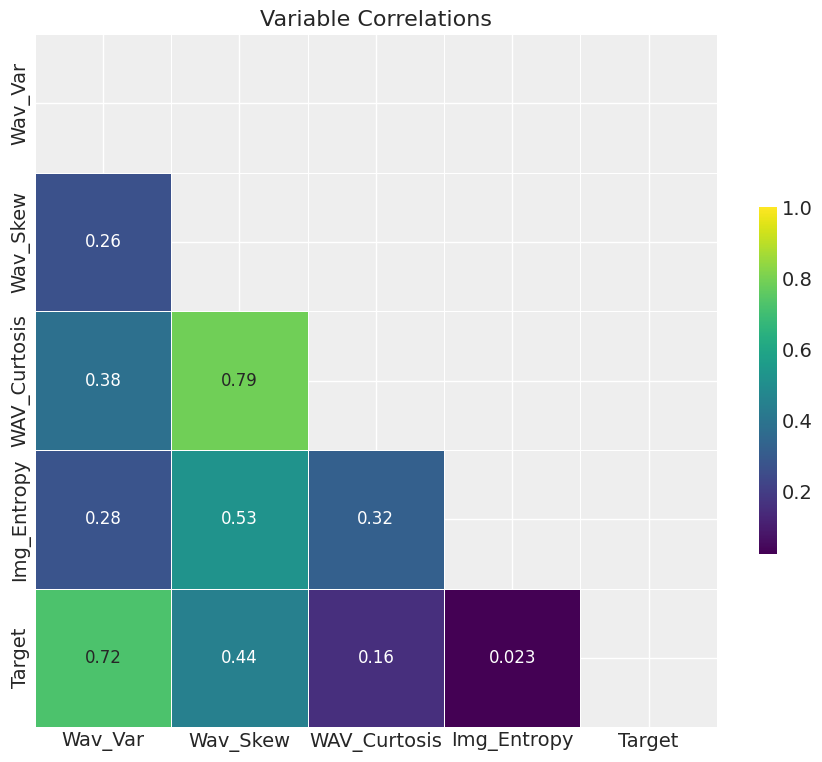

In [9]:
# Variable Correlation 

corr = DF.corr()

mask = np.tri(*corr.shape).T

f, ax = plt.subplots(figsize=(11, 9))
plt.title('Variable Correlations')
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap= 'viridis',
            vmax=1,
            linewidths=0.5,
            cbar_kws={"shrink": 0.5},
            ax=ax,);

In [10]:

# Drop highly corelated variable

DF = DF.drop(columns='Wav_Skew',axis=0)


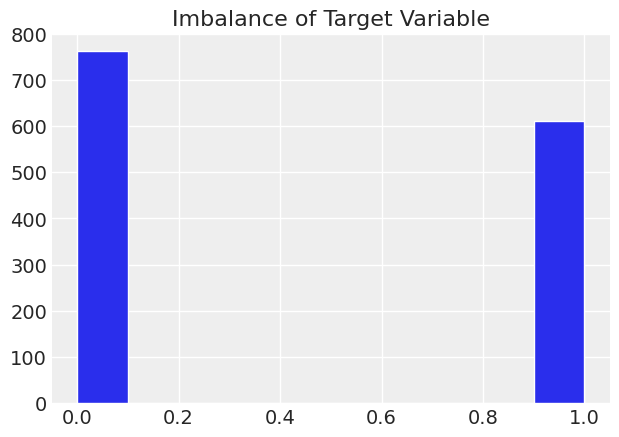

In [11]:

# Balance of target variable. slightly unbalanced byut not too bad

plt.title('Imbalance of Target Variable')
plt.hist(DF['Target']);


<br></br>

***Imbalance of target variable is acceptable. We will now look at variable importance based on a Random Forest model - an ensamble method***

<br></br>

Elapsed time to compute the importances: 0.007 seconds


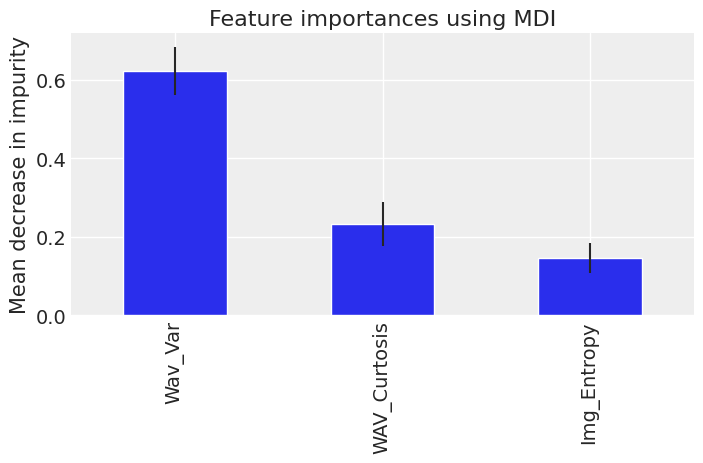

In [13]:
# Test train Split

from sklearn.model_selection import train_test_split

X  = DF.copy()
X = X.drop(columns='Target',axis=0)
y = DF['Target'].copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Random Forest Variable importance analysis - Mean Decrease in Impurity

from sklearn.ensemble import RandomForestClassifier

feature_names = [f"{i}" for i in X.columns]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

import time


start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout(); 

Elapsed time to compute the importances: 0.237 seconds


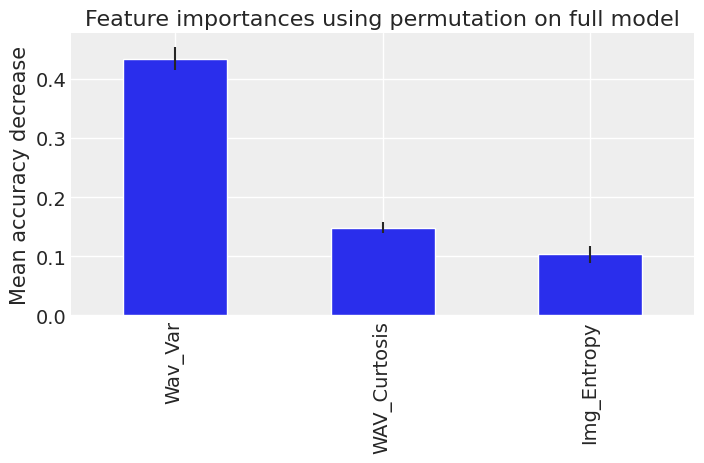

In [15]:
# Random Forest Variable importance analysis - Feature Permutation

from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

<br></br>
We can see that based on the Random Forest model; in analysis of both *mean decrease in impurity* and *mean accuracy decrease through permutation*, that the two most important features are **Wav_Var** and **WAV_Curtosis**. We will use these two variables as well as an interaction term in our Bayesian Logistic Regression model later on, however, we will first conduct principal components analysis in order to try to reduce the dimensionality of the predictor space and use the principal components that capture most of the variance explain as our predictor variables in another logistic regression model. Once PCA is complete, we will compare the two methods side by side below.
<br></br>

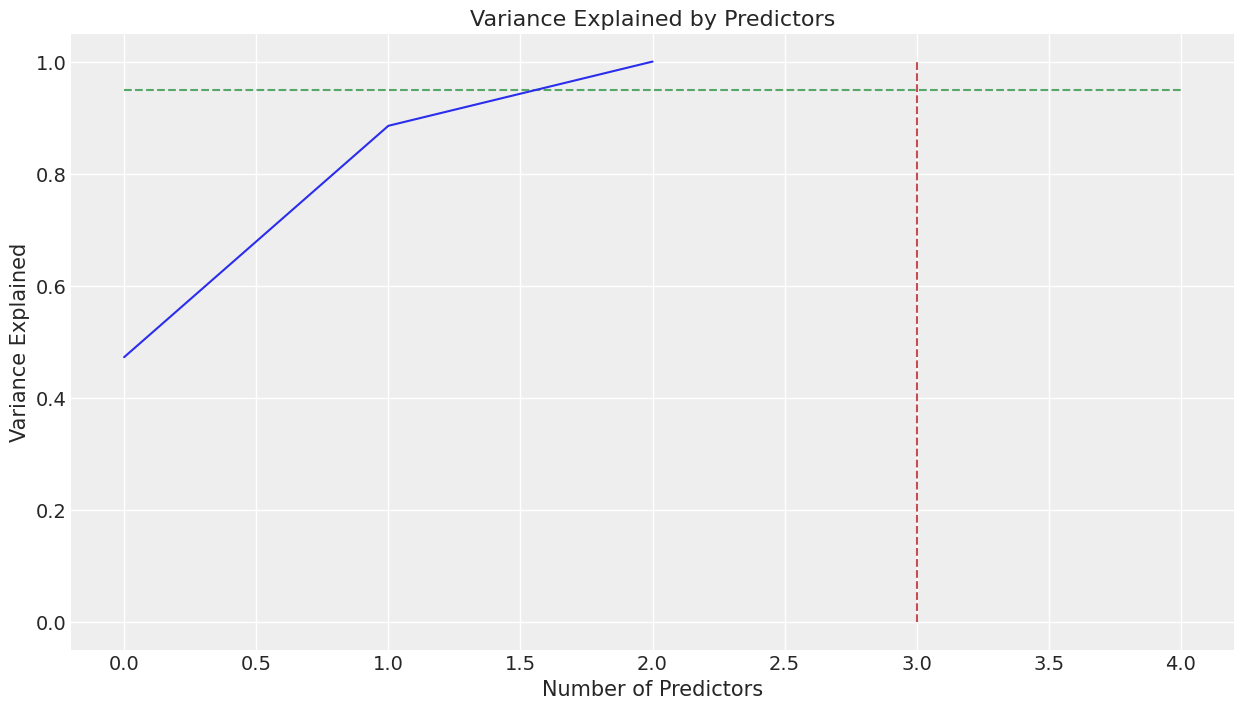

In [16]:

# Principal Components Analysis in order to assess variance explained in the predicotrs, we could use these componenets as predictors as well

from sklearn.decomposition import *

df = DF.copy()

# Split the data into X and y
y = df.pop("Target")
X = df
 
# Split the data into training and test data set

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=42)
 
# Decide the number of PCA components based on the retained information
pca = PCA(random_state=42)
pca.fit(X_train)
variance_explained = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=[15,8])
plt.vlines(x=3, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=4, xmin=0, colors="g", linestyles="--")

plt.title('Variance Explained by Predictors')
plt.xlabel('Number of Predictors')
plt.ylabel('Variance Explained')
plt.plot(variance_explained);

# add - update

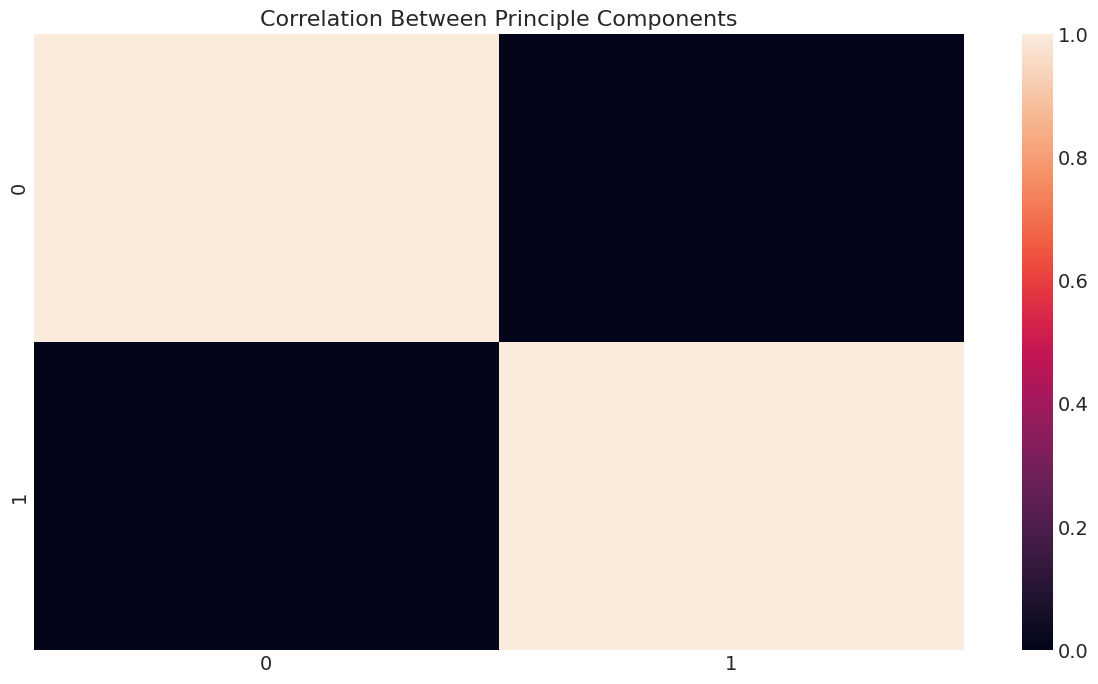

In [17]:
# Keep only the four predictors that explain 95% of the variance

final_pca = PCA(0.80)
pca_train = final_pca.fit_transform(X_train)
 
# Plot Corelations between principle components

corr_matrix = np.corrcoef(pca_train.transpose())
plt.figure(figsize=[15,8])
sns.heatmap(corr_matrix)
plt.title('Correlation Between Principle Components')
plt.show()

In [31]:
# Same PCA ond test Data
pca_test = final_pca.transform(X_test)


# Get final Test and Train data for model building 

pca_train_df = pd.DataFrame(pca_train)
pca_test_df = pd.DataFrame(pca_test)
pca_train_y = pd.DataFrame(y_train)
pca_test_y = pd.DataFrame(y_test)


pca_train_df['Target'] = pca_train_y['Target'].values
pca_test_df['Target'] = pca_test_y['Target'].values

pca_train = pca_train_df.rename({0:'x1',
             1:'x2',
             2:'x3'},axis=1)

pca_test = pca_test_df.rename({0:'x1',
             1:'x2',
             2:'x3'},axis=1)



In [33]:
# Lets set our Dataframes before we conduct some bayesian anbalysis

pca = pca_train.copy()
bayes = DF.copy()


<br></br>
The Principal Components Analysis shows that the first two principal components capture over 80% of the variance explained in the predictor space. We will use these two variables as predictors in a Bayesian logistic regression model, as explained previously. The Model Fitting, Comparison, and Analysis can be seen directly below.
<br></br>

<br></br>

## Bayesian Model Fitting and Analysis:
### PCA Regression and Logistic Regression in PyMC

<br></br>

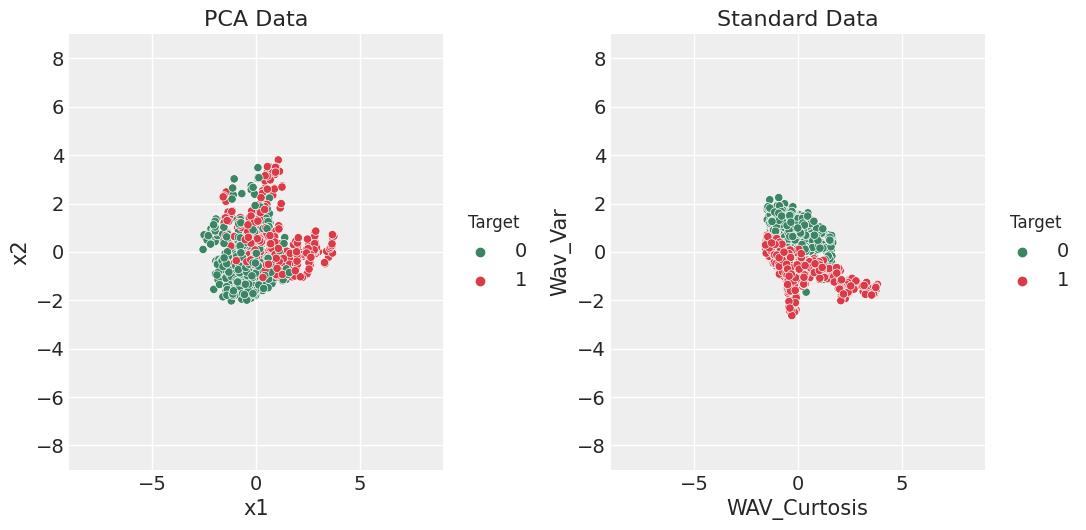

In [34]:

# Visualize the predictor space of each dataset

fig, ax = plt.subplots(1, 2, sharey=False, figsize=(12,7))
sns_c_div = sns.diverging_palette(150, 10, n=2)
fig.tight_layout(pad=7.0)

sns.scatterplot(ax=ax[0],x="x1", y="x2", data=pca, hue="Target", palette=[sns_c_div[0], sns_c_div[-1]])
ax[0].legend(title="Target", loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].set(title="PCA Data", xlim=(-9, 9), ylim=(-9, 9))

sns.scatterplot(ax=ax[1],x="WAV_Curtosis", y="Wav_Var", data=bayes, hue="Target", palette=[sns_c_div[0], sns_c_div[-1]])
ax[1].legend(title="Target", loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set(title="Standard Data", xlim=(-9, 9), ylim=(-9, 9));


<br></br>
Looking at the visualizations of the predictor space above, we can see that the standard Bayesian Logistic Regression model will most likely perform better than the model using the PCA components as predictor variables. This is because the separation boundary between the target variable classes is much more clear, while not necessarily linear. We will test this theory below as we train and test the two models.
<br></br>

In [35]:
import patsy 

SEED = 55


# Define model formula.

formula = "Target ~ x1 * x2"

# Create features.

y, x = patsy.dmatrices(formula_like=formula, data=pca)
y = np.asarray(y).flatten()
labels = x.design_info.column_names
x = np.asarray(x)



In [36]:
SEED = 55


# Define model formula.

formula = "Target ~ WAV_Curtosis * Wav_Var"

# Create features.

y_1, x_1 = patsy.dmatrices(formula_like=formula, data=bayes)
y_1 = np.asarray(y_1).flatten()
labels_1 = x_1.design_info.column_names
x_1 = np.asarray(x_1)


In [37]:
print(f" PCA_labels = {labels}")
print(f" Standard_labels = {labels_1}")

 PCA_labels = ['Intercept', 'x1', 'x2', 'x1:x2']
 Standard_labels = ['Intercept', 'WAV_Curtosis', 'Wav_Var', 'WAV_Curtosis:Wav_Var']


In [38]:
PCA_labels = ['Intercept', 'x1', 'x2', 'x1:x2']
Standard_labels = ['Intercept', 'WAV_Curtosis', 'Wav_Var', 'WAV_Curtosis:Wav_Var']

In [39]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=SEED)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1, y_1, train_size=0.7, random_state=SEED)

In [40]:
with pm.Model() as PCA_model:
    
    # Set data container.
    
    pca_data = pm.Data("data", x_train)
    
    
    # Define GLM family.
    
    family = pm.glm.families.Binomial()
    
    
    
    # Set priors.
    
    priors = {
        "Intercept": pm.Normal.dist(mu=0, sd=1),
        "x1": pm.Normal.dist(mu=0, sd=1),
        "x2": pm.Normal.dist(mu=0, sd=1),
        "x1:x2": pm.Normal.dist(mu=0, sd=1),
    }
    
    # Specify model.
    
    pm.glm.GLM(y=y_train, x=pca_data, family=family, intercept=False, labels=labels, priors=priors)
    
    
    # Configure sampler.
    
    trace = pm.sample(5000, chains=5, tune=1000, target_accept=0.87, random_seed=SEED)
    
    
    
    

/home/jd-ds/miniconda3/envs/pymc3_env/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [x1:x2, x2, x1, Intercept]


In [ ]:
with pm.Model() as Logistic_model:
    
    # Set data container.
    
    standard_data = pm.Data("standard_data", x_train_1)
    
    
    # Define GLM family.
    
    family = pm.glm.families.Binomial()
    
    
    
    # Set priors.
    
    priors_1 = {
        "Intercept": pm.Normal.dist(mu=0, sd=1),
        "WAV_Curtosis": pm.Normal.dist(mu=0, sd=1),
        "Wav_Var": pm.Normal.dist(mu=0, sd=1),
        "WAV_Curtosis:Wav_Var": pm.Normal.dist(mu=0, sd=1)}
    
    # Specify model.
    
    pm.glm.GLM(y=y_train_1, x=standard_data, family=family, intercept=False, 
               labels=labels_1, priors=priors_1)
    
    
    # Configure sampler.
    
    trace_1 = pm.sample(5000, chains=5, tune=1000, target_accept=0.87, random_seed=SEED)
    
    
    
    

In [ ]:
# Plot chains.

az.plot_trace(data=trace,figsize=(20,15));

In [ ]:
# Plot chains.

az.plot_trace(data=trace_1,figsize=(20,15));

<br></br>
Above we can see the trace plots that result from fitting our two models in PyMC. PyMC used the standard No U-Turn Sampler (NUTS) which is a form of Markov Chain Monte Carlo sampling. The left side of the trace plots show probability distributions for each predictor variable and the intercept. The right side shows the chains sampled from the likelihood distribution at each iteration of the sampling. we can see that the plots are stable, however, the data was standardized in the pre-processing stage; so, we will do some more checks in order to validate that our models properly sampled from the likelihood distributions in order to estimate the posterior distributions for each model.
<br></br>

## Evaluate Model Performance:
### Posterior Predictive Checks with Out of Sample Data (Test Data)
<br></br>

In [ ]:
# Update data reference.

pm.set_data({"data": x_test}, model=PCA_model)

pm.set_data({"standard_data": x_test_1}, model=Logistic_model)


# Generate posterior samples.

ppc_test = pm.sample_posterior_predictive(trace, model=PCA_model, samples=1000)

ppc_test_1 = pm.sample_posterior_predictive(trace_1, model=Logistic_model, samples=1000)


In [ ]:
# Compute the point prediction by taking the mean
# and defining the category via a threshold.

p_test_pred = ppc_test["y"].mean(axis=0)
y_test_pred = (p_test_pred >= 0.5).astype("int")

p_test_pred_1 = ppc_test_1["y"].mean(axis=0)
y_test_pred_1 = (p_test_pred_1 >= 0.5).astype("int")

In [ ]:
from sklearn.metrics import accuracy_score

print(f" PCA accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")

print(f" Logistic accuracy = {accuracy_score(y_true=y_test_1, y_pred=y_test_pred_1): 0.3f}")

<br></br>
The Accuracy of the bayesian logistic regression model is ~90% while the PCA model only performed with ~75% accuracy. This validates our theory that the seperation in the predictor space for the standard variables indicated better performance for the logistic regression mode. Accuracy, however, could potentially be a misleading metric for how well a model performs, especially when the target variable is imbalanced. The imbalance of our target variable did not seem to be that large, but we should still check the area under the curve (AUC) scores just to be sure.
<br></br>

In [ ]:
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=p_test_pred, pos_label=1, drop_intermediate=False)

fpr_1, tpr_1, thresholds_1 = roc_curve(y_true=y_test_1, 
                                       y_score=p_test_pred_1, pos_label=1, drop_intermediate=False)


roc_auc = auc(fpr, tpr)
roc_auc_1 = auc(fpr_1, tpr_1)

fig, ax = plt.subplots(1, 2, sharey=True,sharex=True, figsize=(12,7))
fig.tight_layout(pad=5)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display_1 = RocCurveDisplay(fpr=fpr_1, tpr=tpr_1, roc_auc=roc_auc_1)

roc_display = roc_display.plot(ax=ax[0], marker="o",  markersize=4,c='#5C15D2')
roc_display_1 = roc_display_1.plot(ax=ax[1], marker="o",  markersize=4,c='#5C15D2')

ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes,c='orange')
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes,c='orange')

ax[0].set(title="PCA ROC")
ax[1].set(title="Logistic ROC");

<br></br>
The AUC-ROC shows us the False Positive Rate against the True positive rate, with an orange line across the diagonal of the plot. Anything below that orange line indicates the model is performing worse than randomly guessing, anything to the left of the orange line indicates better than random guessing. The closer to the top left corner of the plot (the closer the AUC is to 1.0), the better the model performs in terms of false positives. We can see that our Bayesian logistic regression model  confirms the accuracy comparison, with and AUC 0f 0.96; compared to the PCA models AUC score of 0.85. Below we will visualize the decision boundaries for each model, which will allow us to do a visual check of our model’s performance on the out of sample data. We will gain more understanding of why our standard logistic regression model is performing better than the PCA model.
<br></br>

In [ ]:
# Construct PCA grid.
x1_grid = np.linspace(start=-9, stop=9, num=300)
x2_grid = x1_grid

x1_mesh, x2_mesh = np.meshgrid(x1_grid, x2_grid)

x_grid = np.stack(arrays=[x1_mesh.flatten(), x2_mesh.flatten()], axis=1)

# Create features on the grid.
x_grid_ext = patsy.dmatrix(formula_like="x1 * x2", data=dict(x1=x_grid[:, 0], x2=x_grid[:, 1]))

x_grid_ext = np.asarray(x_grid_ext)

# Generate model predictions on the grid.
pm.set_data({"data": x_grid_ext}, model=PCA_model)
ppc_grid = pm.sample_posterior_predictive(trace, model=PCA_model, samples=1000)

In [ ]:
# Construct Logistic Regression grid.

x1_grid_1 = np.linspace(start=-9, stop=9, num=300)
x2_grid_1 = x1_grid_1

x1_mesh_1, x2_mesh_1 = np.meshgrid(x1_grid_1, x2_grid_1)

x_grid_1 = np.stack(arrays=[x1_mesh_1.flatten(), x2_mesh_1.flatten()], axis=1)

# Create features on the grid.
x_grid_ext_1 = patsy.dmatrix(formula_like="x1 * x2", data=dict(x1=x_grid_1[:, 0], x2=x_grid_1[:, 1]))

x_grid_ext_1 = np.asarray(x_grid_ext_1)

# Generate model predictions on the grid.
pm.set_data({"standard_data": x_grid_ext_1}, model=Logistic_model)
ppc_grid_1 = pm.sample_posterior_predictive(trace_1, model=Logistic_model, samples=1000)

In [ ]:
numerator = -(trace["Intercept"].mean(axis=0) + trace["x1"].mean(axis=0) * x1_grid)
denominator = trace["x2"].mean(axis=0) + trace["x1:x2"].mean(axis=0) * x1_grid
bd_grid = numerator / denominator

grid_df = pd.DataFrame(x_grid, columns=["x1", "x2"])
grid_df["p"] = ppc_grid["y"].mean(axis=0)
grid_df.sort_values("p", inplace=True)

p_grid = grid_df.pivot(index="x2", columns="x1", values="p").to_numpy()

In [ ]:
numerator_1 = -(trace_1["Intercept"].mean(axis=0) + trace_1["WAV_Curtosis"].mean(axis=0) * x1_grid_1)
denominator_1 = trace_1["Wav_Var"].mean(axis=0) + trace_1["WAV_Curtosis:Wav_Var"].mean(axis=0) * x1_grid_1
bd_grid_1 = numerator_1 / denominator_1

grid_df_1 = pd.DataFrame(x_grid_1, columns=["WAV_Curtosis", "Wav_Var"])
grid_df_1["p"] = ppc_grid_1["y"].mean(axis=0)
grid_df_1.sort_values("p", inplace=True)

p_grid_1 = grid_df_1.pivot(index="Wav_Var", columns="WAV_Curtosis", values="p").to_numpy()

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=False,sharex=False, figsize=(12,7))
fig.tight_layout(pad=8)
cmap = sns.diverging_palette(150, 10, n=50, as_cmap=True)

sns.scatterplot(
    x=x_test[:, 1].flatten(),
    y=x_test[:, 2].flatten(),
    hue=y_test,
    palette=[sns_c_div[0], sns_c_div[-1]],
    ax=ax[0],)

sns.lineplot(x=x1_grid, y=bd_grid, color="black", ax=ax[0])
ax[0].contourf(x1_grid, x2_grid, p_grid, cmap=cmap, alpha=0.3)

ax[0].legend(title="y", loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].lines[0].set_linestyle("dotted")
ax[0].set(title="PCA Decision Boundary", xlim=(-9, 9), ylim=(-9, 9), xlabel="x1", ylabel="x2")

sns.scatterplot(
    x=x_test_1[:, 1].flatten(),
    y=x_test_1[:, 2].flatten(),
    hue=y_test_1,
    palette=[sns_c_div[0], sns_c_div[-1]],
    ax=ax[1],)

sns.lineplot(x=x1_grid_1, y=bd_grid_1, color="black", ax=ax[1])
ax[1].contourf(x1_grid_1, x2_grid_1, p_grid_1, cmap=cmap, alpha=0.3)

ax[1].legend(title="y", loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].lines[0].set_linestyle("dotted")
ax[1].set(title="Logistic Model Decision Boundary", xlim=(-9, 9), ylim=(-9, 9), xlabel="Wav_Curtosis", ylabel="Wav_Var");

<br></br>
We can clearly see based on the Accuracy score, ROC-AUC score, and the model Decision boundary; that our standard Bayesian logistic regression model performed much better than our PCA model. This is probably because the Principal Components analysis does not take the target variable into account. It only takes the variance explained by the predictor variables into account and therefore, we are most likely missing important information contained within the relationship between the target variable and the predictor variables. With a Bayesian Logistic Regression model, with priors included we were able to make point estimations by sampling from the posterior distribution with ~90% accuracy in identifying authentic banknotes. We used only the two most important features that were identified by our Random Forest model.
<br></br>